In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment-dataset/Data_Analyst_Assignment_Dataset.csv


In [3]:
#read the dataset into the notebook
df1=pd.read_csv(r"/kaggle/input/assignment-dataset/Data_Analyst_Assignment_Dataset.csv")
#convert datatype of 'Bounce string' column to string datatype
df1['Bounce String']=df1['Bounce String'].astype("string")
#printing the datframe to understand column types
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24582 entries, 0 to 24581
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Amount Pending    24582 non-null  int64  
 1   State             24582 non-null  object 
 2   Tenure            24582 non-null  int64  
 3   Interest Rate     24582 non-null  float64
 4   City              24582 non-null  object 
 5   Bounce String     24582 non-null  string 
 6   Disbursed Amount  24582 non-null  int64  
 7   Loan Number       24582 non-null  object 
dtypes: float64(1), int64(3), object(3), string(1)
memory usage: 1.5+ MB
None


In [4]:
#calculate tenure in months
df1['Tenure(months)']=df1['Tenure']*12
#Monthly EMI if interest rate is 0
df1.loc[df1['Interest Rate']==0,'Monthly_EMI']=(df1['Disbursed Amount']/df1['Tenure']).round(2)
#Monthly EMI if interest rate is not 0
df1.loc[df1['Interest Rate']!=0,'Monthly_EMI']=((df1['Disbursed Amount']*((df1['Interest Rate'])/100)*((1+((df1['Interest Rate'])/100))**df1['Tenure(months)']))/(((1+((df1['Interest Rate'])/100))**df1['Tenure(months)'])-1)).round(2)



# calculate Risk Labels for all borrowers 
def risk_label(a):
    if a=="FEMI": #New customers
        return 'unknown risk' 
    #low risk - Customers who have not bounced in the last 6 months
    elif (a[-6:].count('B')+a[-6:].count('L'))==0:   
        return 'low risk'
    #Medium Risk - These are customers who have bounced max twice in the last 6 months - The bounce should not have occurred in the last month 
    elif (a[-6:].count('B')+a[-6:].count('L'))<2 and a[-1]!="B":
        return 'Medium risk'
    #High risk - every other customer
    else:
        return 'high risk'

#create new column to apply risk lables to each row through apply method    
df1['Risk lable']=df1['Bounce String'].apply(risk_label)
print(df1)
#print(df1[df1['Tenure Label']=='late'])
#print(df1.loc[5000:5050])




       Amount Pending           State  Tenure  Interest Rate       City  \
0                 963       Karnataka      11           7.69  Bangalore   
1                1194       Karnataka      11           6.16  Bangalore   
2                1807       Karnataka      14           4.24     Hassan   
3                2451       Karnataka      10           4.70  Bangalore   
4                2611       Karnataka      10           4.41     Mysore   
...               ...             ...     ...            ...        ...   
24577             899  Andhra Pradesh       8           0.00   Chittoor   
24578            2699  Andhra Pradesh       8           0.00    Krishna   
24579            1540  Andhra Pradesh       8           0.00    Krishna   
24580             824  Andhra Pradesh       8           0.00     Guntur   
24581            2254  Andhra Pradesh      11           0.00    Kurnool   

      Bounce String  Disbursed Amount Loan Number  Tenure(months)  \
0               SSS           

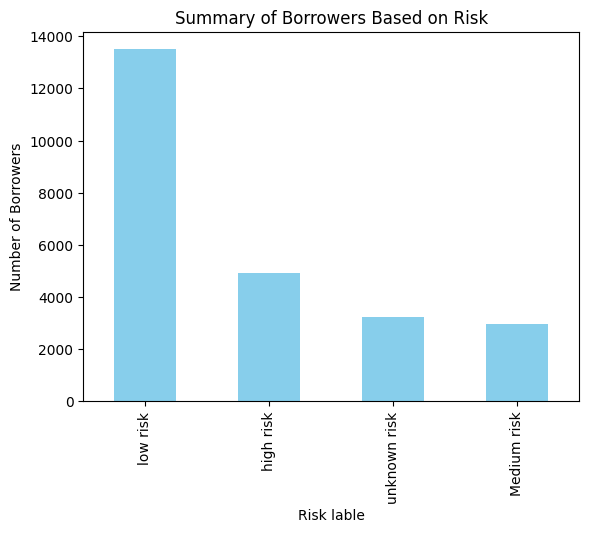

In [5]:
import matplotlib.pyplot as plt
#create chart to vizualize the distribution of risk labels
risk_counts = df1['Risk lable'].value_counts()
risk_counts.plot(kind='bar', color='skyblue')
plt.title('Summary of Borrowers Based on Risk')
plt.xlabel('Risk lable')
plt.ylabel('Number of Borrowers')
plt.show()

In [6]:

#calculate Tenure Labels for all borrowers 
def Tenure_label(a):
    #Early tenure - Customers who are in the book for 3 months
    if len(a['Bounce String']) == 2 or a['Bounce String']=='FEMI' :
        return 'early'
    #Late tenure - Customers who are 3 months away from closing the loan
    elif (a['Tenure(months)']- (len(a['Bounce String'])+1))==3:
        return 'late'
    #Mid tenure - Everyone else
    else:
        return 'mid'

#create new column to apply tenure lables to each row through apply method    
df1['Tenure Label'] = df1.apply(Tenure_label, axis=1)

#print(df1[df1['Tenure Label']=='late'])
print(df1)

       Amount Pending           State  Tenure  Interest Rate       City  \
0                 963       Karnataka      11           7.69  Bangalore   
1                1194       Karnataka      11           6.16  Bangalore   
2                1807       Karnataka      14           4.24     Hassan   
3                2451       Karnataka      10           4.70  Bangalore   
4                2611       Karnataka      10           4.41     Mysore   
...               ...             ...     ...            ...        ...   
24577             899  Andhra Pradesh       8           0.00   Chittoor   
24578            2699  Andhra Pradesh       8           0.00    Krishna   
24579            1540  Andhra Pradesh       8           0.00    Krishna   
24580             824  Andhra Pradesh       8           0.00     Guntur   
24581            2254  Andhra Pradesh      11           0.00    Kurnool   

      Bounce String  Disbursed Amount Loan Number  Tenure(months)  \
0               SSS           

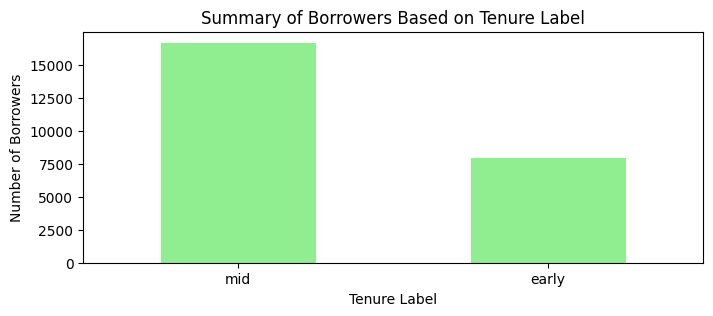

In [7]:

#create chart to vizualize the distribution of tenure labels
tenure_counts = df1['Tenure Label'].value_counts()
plt.figure(figsize=(8, 3))
tenure_counts.plot(kind='bar', color='lightgreen')
plt.title('Summary of Borrowers Based on Tenure Label')
plt.xlabel('Tenure Label')
plt.ylabel('Number of Borrowers')
plt.xticks(rotation=0)
plt.show()

In [8]:
#calculate Ticket sizes Labels for all borrowers 
df1['Total Amount Pending'] = df1.groupby('Loan Number')['Amount Pending'].transform('sum')
df1.sort_values(by='Total Amount Pending', inplace=True)
df1['Cumulative Amount Pending'] = df1['Total Amount Pending'].cumsum()
total_amount_pending = df1['Total Amount Pending'].sum()
split_value = total_amount_pending / 3
df1['Ticket Size'] = pd.cut(df1['Cumulative Amount Pending'], bins=[0, split_value, 2*split_value, total_amount_pending], labels=['Low ticket size', 'Medium ticket size', 'High ticket size'])
#print(df1)
print(df1[df1['Ticket Size']=='Low ticket size'])

       Amount Pending           State  Tenure  Interest Rate          City  \
1534              423     Maharashtra      11          11.84        Sangli   
1982              444      Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889               451     Maharashtra       7          37.92          Pune   
1486              522     Maharashtra      11          12.83          Pune   
265               522       Karnataka      11          12.83      Bagalkot   
...               ...             ...     ...            ...           ...   
15473            1593      Tamil Nadu       8           0.00       Chennai   
15455            1593      Tamil Nadu       8           0.00       Chennai   
23942            1593  Andhra Pradesh       8           0.00        Guntur   
20757            1593          Kerala       8           0.00        IDUKKI   
3248             1593       Karnataka       8           0.00         Bidar   

      Bounce String  Disbursed Amount Loan Number  Tenure(month

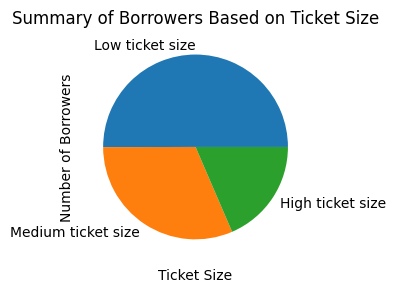

In [9]:

#create chart to vizualize the distribution of ticket size labels
ticket_size_counts = df1['Ticket Size'].value_counts()
plt.figure(figsize=(5, 3))
ticket_size_counts.plot(kind='pie')
plt.title('Summary of Borrowers Based on Ticket Size')
plt.xlabel('Ticket Size')
plt.ylabel('Number of Borrowers')
plt.show()

In [10]:
#Segmenting borrowers to minimize total spend 
def spend(a):
    if (a['Bounce String'].count('B')+a['Bounce String'].count('L'))==0 or a['Bounce String']=="FEMI" or a['Risk lable']=='low risk' or a['Ticket Size']=='Low ticket size':
        return 'watsappbot' 
    elif a['Risk lable']=='Medium risk'or a['Ticket Size']=='Medium ticket size':
        return 'voicebot'
    else:
        return 'human calling'
    
df1['spend']=df1.apply(spend,axis=1)
print(df1)
#print(df1[df1['spend']==10])
#print(df1.loc[1534:1535])

channel_counts = df1['spend'].value_counts()

# Calculate the total cost for each channel
whatsapp_cost = channel_counts['watsappbot'] * 5
voice_cost = channel_counts['voicebot'] * 10
human_cost = channel_counts['human calling'] * 50

total_cost = whatsapp_cost + voice_cost + human_cost
print(total_cost)

       Amount Pending           State  Tenure  Interest Rate          City  \
1534              423     Maharashtra      11          11.84        Sangli   
1982              444      Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889               451     Maharashtra       7          37.92          Pune   
1486              522     Maharashtra      11          12.83          Pune   
265               522       Karnataka      11          12.83      Bagalkot   
...               ...             ...     ...            ...           ...   
15090           12500     Maharashtra       8           0.00    Aurangabad   
5278            12500  Madhya Pradesh       8           0.00        Indore   
23089           12500          Kerala       8           0.00    MALAPPURAM   
9776            12500     Maharashtra       8           0.00      Kolhapur   
13706           13349     Maharashtra       8           0.00        Nagpur   

      Bounce String  Disbursed Amount Loan Number  Tenure(month

In [11]:

#Segmenting borrowers to minimize total spend if the condition of low ticket size is not considered which increases the total spend
def spend(a):
    if (a['Bounce String'].count('B')+a['Bounce String'].count('L'))==0 or a['Bounce String']=="FEMI" or a['Risk lable']=='low risk':
        return 'watsappbot' 
    elif a['Risk lable']=='Medium risk'or a['Ticket Size']=='Medium ticket size':
        return 'voicebot'
    else:
        return 'human calling'
    
df1['spend']=df1.apply(spend,axis=1)
print(df1)
#print(df1[df1['spend']==10])
#print(df1.loc[1534:1535])

channel_counts = df1['spend'].value_counts()

# Calculate the total cost for each channel
whatsapp_cost = channel_counts['watsappbot'] * 5
voice_cost = channel_counts['voicebot'] * 10
human_cost = channel_counts['human calling'] * 50

total_cost = whatsapp_cost + voice_cost + human_cost
print(total_cost)

       Amount Pending           State  Tenure  Interest Rate          City  \
1534              423     Maharashtra      11          11.84        Sangli   
1982              444      Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889               451     Maharashtra       7          37.92          Pune   
1486              522     Maharashtra      11          12.83          Pune   
265               522       Karnataka      11          12.83      Bagalkot   
...               ...             ...     ...            ...           ...   
15090           12500     Maharashtra       8           0.00    Aurangabad   
5278            12500  Madhya Pradesh       8           0.00        Indore   
23089           12500          Kerala       8           0.00    MALAPPURAM   
9776            12500     Maharashtra       8           0.00      Kolhapur   
13706           13349     Maharashtra       8           0.00        Nagpur   

      Bounce String  Disbursed Amount Loan Number  Tenure(month

0.8297670575405458


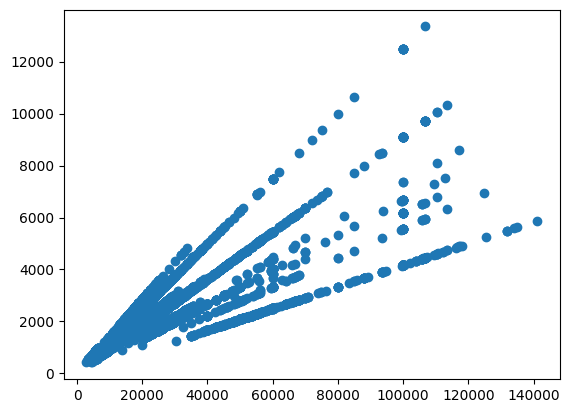

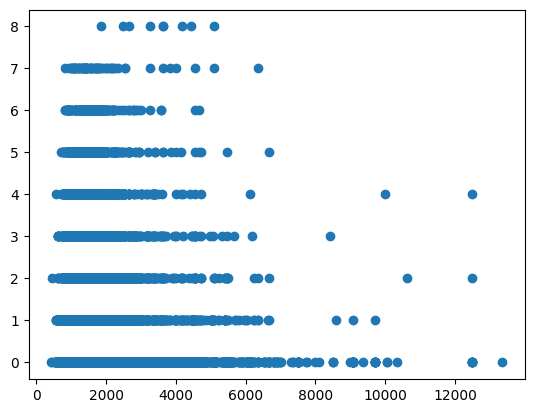

In [12]:
import matplotlib.pyplot as plt
#calculating the no of months the borrowers has bounced
df1['countbounce']=df1['Bounce String'].apply(lambda a: a.count('B')+a.count('L') )

#calculate correlation coefficient for Amount Pending vs Disbursed Amount 
print(df1['Amount Pending'].corr(df1['Disbursed Amount']))
#Scatter plots to vizualize relation
plt.scatter(df1['Disbursed Amount'],df1['Amount Pending'])
plt.show()   
plt.scatter(df1['Amount Pending'],df1['countbounce'])
plt.show()

In [17]:
#check risk labels for each state followed by city
a=df1.groupby(['State','City'])['Risk lable'].value_counts().reset_index(name="count")
print(a)


#distribution of risk labels for each city
pivot_df = a.pivot_table(index=['City'], columns='Risk lable', values='count', fill_value=0)
sorted_df = pivot_df.sort_values(by='high risk', ascending=False)
print(sorted_df)

#distribution of high risk labels among states
high_risk_sum = df1[df1['Risk lable'] == 'high risk'].groupby(['State','City'])['Risk lable'].count()
sorted_city = high_risk_sum.sort_values(ascending=False)
print(sorted_city)


              State        City    Risk lable  count
0    Andhra Pradesh  ANANTHAPUR      low risk     43
1    Andhra Pradesh  ANANTHAPUR     high risk     15
2    Andhra Pradesh  ANANTHAPUR   Medium risk      8
3    Andhra Pradesh  ANANTHAPUR  unknown risk      7
4    Andhra Pradesh    Chittoor      low risk     75
..              ...         ...           ...    ...
698       Telangana   Nizamabad  unknown risk      9
699       Telangana    Warangal      low risk     55
700       Telangana    Warangal     high risk     13
701       Telangana    Warangal  unknown risk     10
702       Telangana    Warangal   Medium risk      8

[703 rows x 4 columns]
Risk lable  Medium risk  high risk  low risk  unknown risk
City                                                      
Pune              261.0      403.0     914.0         202.0
Aurangabad         97.0      184.0     367.0          45.0
Hyderabad          86.0      169.0     452.0          77.0
Indore             97.0      166.0     320.0 